In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image
from IPython.display import display
import cv2
from PIL import ImageFile
import torchvision.transforms as transforms
ImageFile.LOAD_TRUNCATED_IMAGES = True

import glob
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

In [4]:
#First let's define our data augmentation rules or transforms

# define transformations for train
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(p=.30),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# define transformations for test
# for test we dont need much of augmentations other than converting to tensors and normalizing the pictures
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [5]:
train_data = datasets.CIFAR10('./cifar10/', train=True,
                              download=True, transform=train_transform)
test_data = datasets.CIFAR10('./cifar10/', train=False,
                             download=True, transform=test_transform)

100%|██████████| 170498071/170498071 [00:01<00:00, 103174621.94it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10/
Files already downloaded and verified


In [6]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.15

In [7]:
# Dividing the training dataset further for validation set
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [8]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [9]:
#  data loaders (combine dataset and sampler)
#Dataloader provides an iterable over the specified dataset by combining a dataset with a sampler.

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

In [10]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [11]:
#  function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

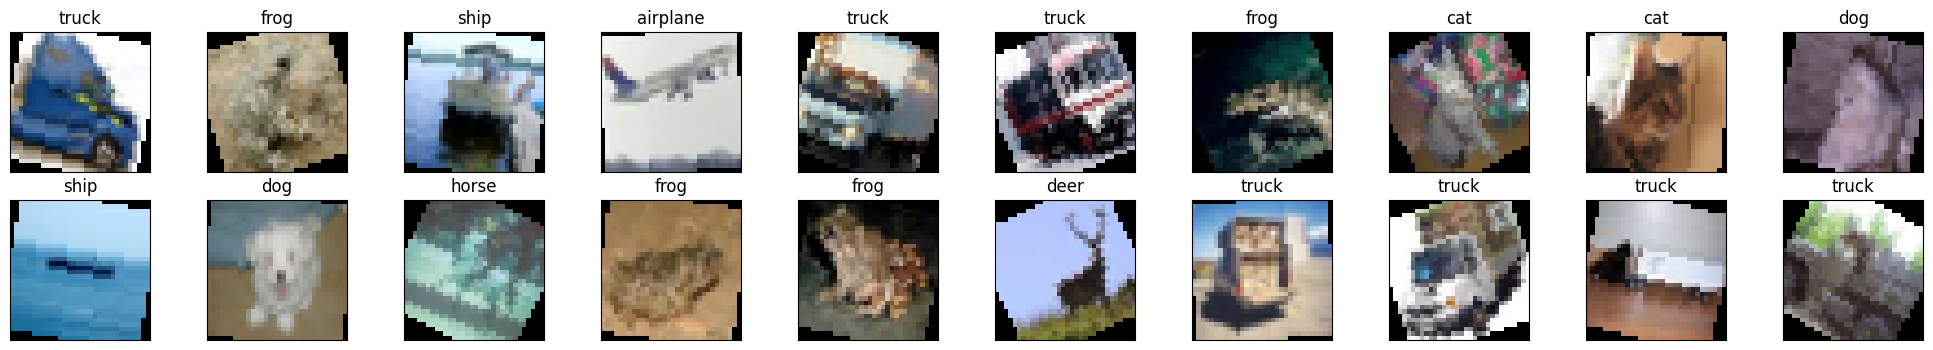

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)  # replace _next_ with next
images = images.numpy()  # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])

    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

plt.show()  # Don't forget to add this to actually display the plot


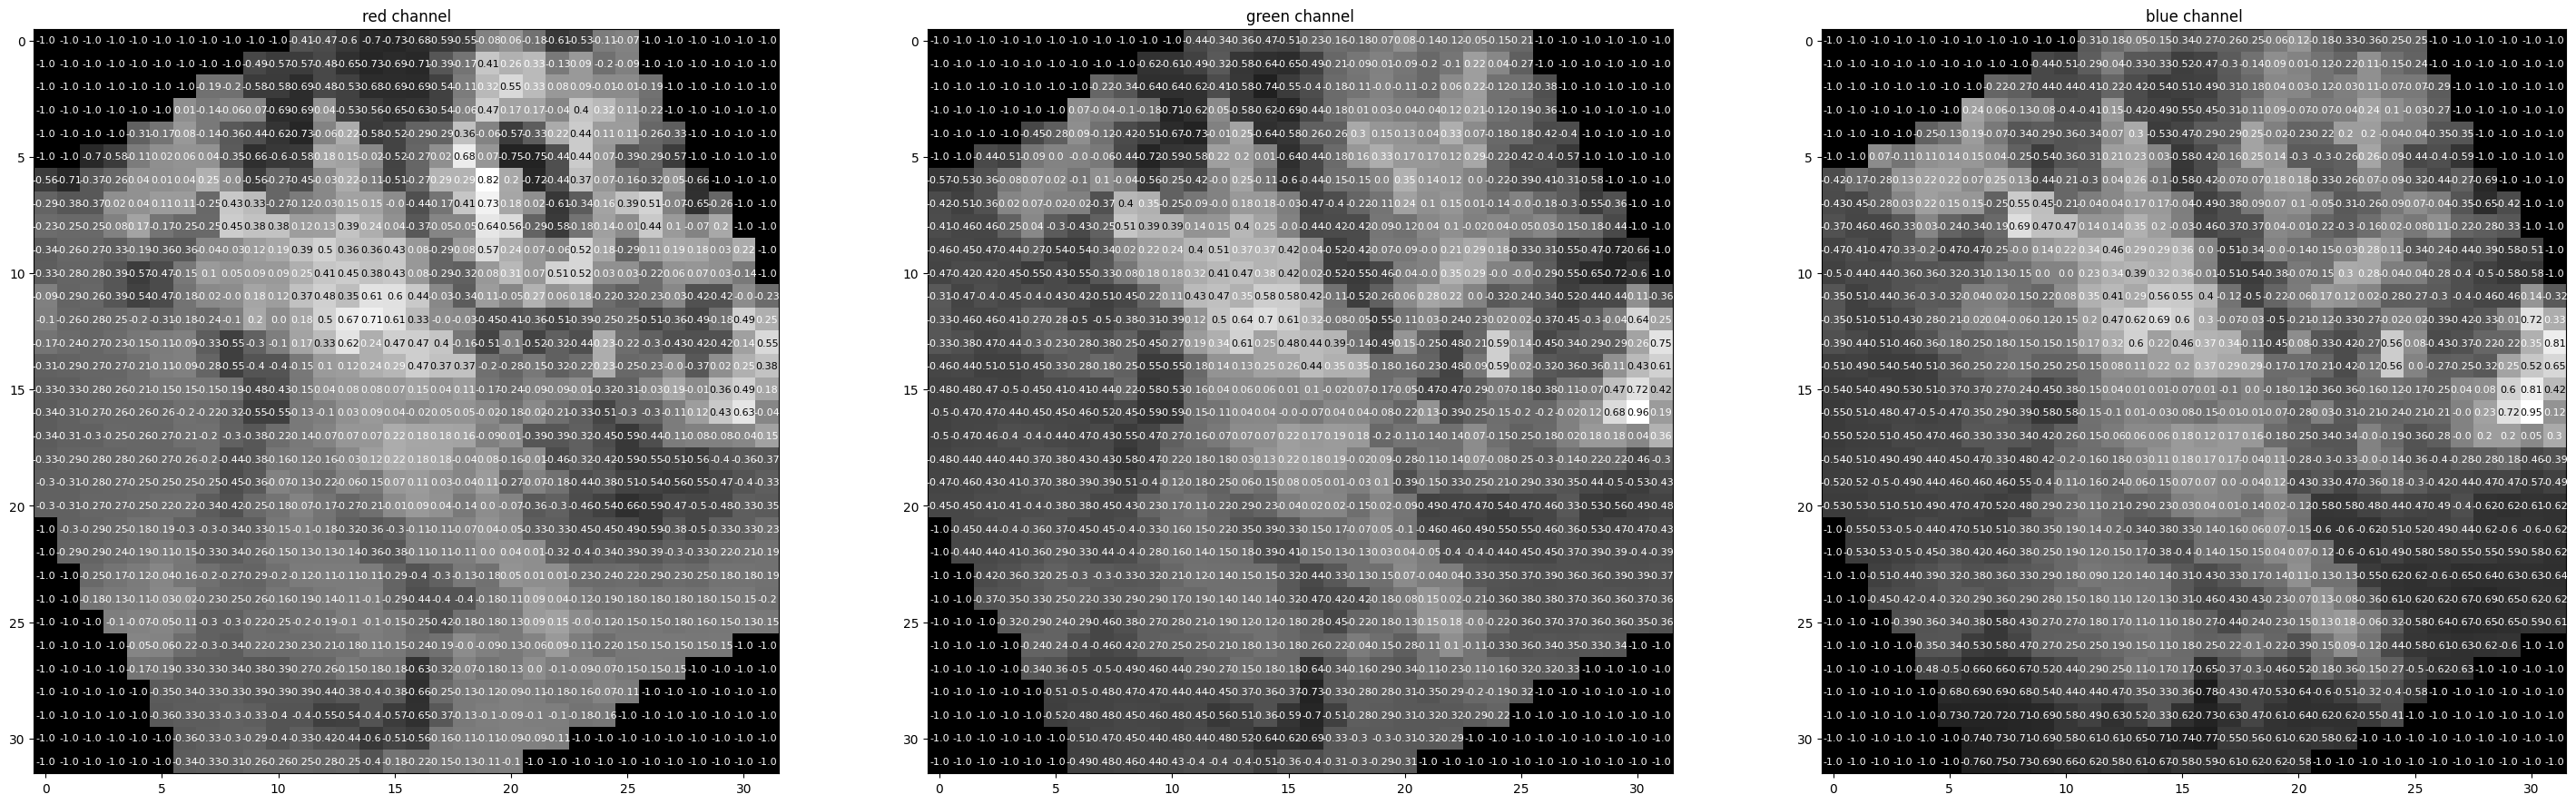

In [18]:
# let's look into details of normalized RGB

rgb_img = np.squeeze(images[7])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [19]:
# check if CUDA is available
use_gpu = torch.cuda.is_available()

if  use_gpu:
    print('CUDA is available.  Training on CPU ...')
else:
    print('CUDA is not available!  Training on GPU ...')

CUDA is not available!  Training on GPU ...


In [20]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if use_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [21]:
!pip install torchsummary

In [22]:
#let's see the model
from torchsummary import summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
           Dropout-7                 [-1, 1024]               0
            Linear-8                  [-1, 500]         512,500
           Dropout-9                  [-1, 500]               0
           Linear-10                   [-1, 10]           5,010
Total params: 541,094
Trainable params: 541,094
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.29
Params size (MB): 2.06
Estimated T

In [23]:
#  loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [24]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if use_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if use_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.187238 	Validation Loss: 1.995869
Validation loss decreased (inf --> 1.995869).  Saving model ...
Epoch: 2 	Training Loss: 1.916269 	Validation Loss: 1.815552
Validation loss decreased (1.995869 --> 1.815552).  Saving model ...
Epoch: 3 	Training Loss: 1.734004 	Validation Loss: 1.663087
Validation loss decreased (1.815552 --> 1.663087).  Saving model ...
Epoch: 4 	Training Loss: 1.616211 	Validation Loss: 1.572889
Validation loss decreased (1.663087 --> 1.572889).  Saving model ...
Epoch: 5 	Training Loss: 1.536092 	Validation Loss: 1.484915
Validation loss decreased (1.572889 --> 1.484915).  Saving model ...
Epoch: 6 	Training Loss: 1.479023 	Validation Loss: 1.412137
Validation loss decreased (1.484915 --> 1.412137).  Saving model ...
Epoch: 7 	Training Loss: 1.429540 	Validation Loss: 1.702910
Epoch: 8 	Training Loss: 1.379123 	Validation Loss: 1.545102
Epoch: 9 	Training Loss: 1.337203 	Validation Loss: 1.373659
Validation loss decreased (1.412137 --> 1.

In [25]:
model_transfer = models.googlenet(pretrained=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 137MB/s]


In [26]:
print(model_transfer)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [27]:
for param in model_transfer.parameters():
    param.requires_grad = False

# replace the last fully connected layer with a Linnear layer 133 output
in_features = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(in_features, 10)

if use_gpu:
    model_transfer = model_transfer.cuda()

In [28]:
summary(model_transfer, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
       BasicConv2d-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
       BasicConv2d-7             [-1, 64, 8, 8]               0
            Conv2d-8            [-1, 192, 8, 8]         110,592
       BatchNorm2d-9            [-1, 192, 8, 8]             384
      BasicConv2d-10            [-1, 192, 8, 8]               0
        MaxPool2d-11            [-1, 192, 4, 4]               0
           Conv2d-12             [-1, 64, 4, 4]          12,288
      BatchNorm2d-13             [-1, 64, 4, 4]             128
      BasicConv2d-14             [-1, 6

In [29]:
criterion = nn.CrossEntropyLoss()
model_transfer_grad_paramaters = filter(lambda p: p.requires_grad, model_transfer.parameters())
optimizer = torch.optim.Adam(model_transfer_grad_paramaters, lr=0.001)

In [30]:
# number of epochs to train the model
n_epochs = 10

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model_transfer.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if use_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_transfer(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################
    model_transfer.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if use_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_transfer(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model_transfer.state_dict(), 'model_transfer_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.008107 	Validation Loss: 2.013468
Validation loss decreased (inf --> 2.013468).  Saving model ...
Epoch: 2 	Training Loss: 1.944141 	Validation Loss: 1.937900
Validation loss decreased (2.013468 --> 1.937900).  Saving model ...
Epoch: 3 	Training Loss: 1.945282 	Validation Loss: 1.940997
Epoch: 4 	Training Loss: 1.943331 	Validation Loss: 2.017792
Epoch: 5 	Training Loss: 1.945458 	Validation Loss: 1.912804
Validation loss decreased (1.937900 --> 1.912804).  Saving model ...
Epoch: 6 	Training Loss: 1.945035 	Validation Loss: 1.922198
Epoch: 7 	Training Loss: 1.938245 	Validation Loss: 1.927899
Epoch: 8 	Training Loss: 1.936720 	Validation Loss: 1.976523
Epoch: 9 	Training Loss: 1.947149 	Validation Loss: 1.892819
Validation loss decreased (1.912804 --> 1.892819).  Saving model ...
Epoch: 10 	Training Loss: 1.943161 	Validation Loss: 1.924038


In [31]:
# Load the saved model
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [35]:
ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])


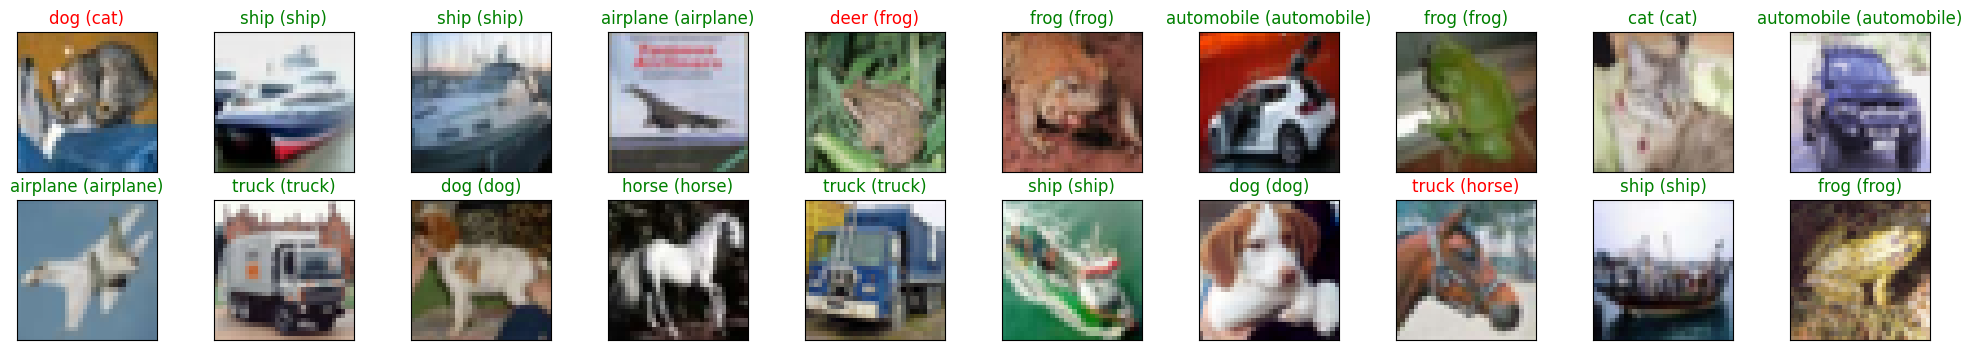

In [36]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)  # replace dataiter.next() with next(dataiter)
images = images.numpy()

# move model inputs to cuda, if GPU available
if use_gpu:
    images = torch.tensor(images).cuda()  # convert to PyTorch tensor and move to GPU
else:
    images = torch.tensor(images)  # convert to PyTorch tensor

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not use_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])  # If using GPU, move images back to CPU before displaying
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx] == labels[idx].item() else "red"))

plt.show()  # Don't forget to add this to actually display the plot


In [37]:
# Load the saved model
model_transfer.load_state_dict(torch.load('./model_transfer_cifar.pt'))

<All keys matched successfully>

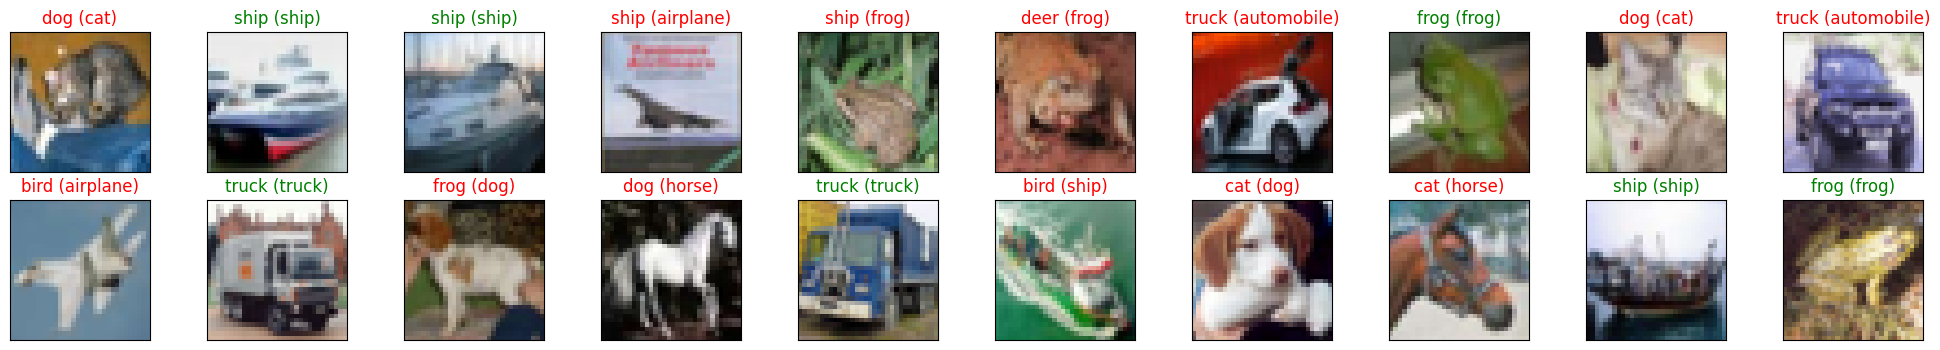

In [39]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)  # replace dataiter.next() with next(dataiter)
images = images.numpy()

# move model inputs to cuda, if GPU available
if use_gpu:
    images = torch.tensor(images).cuda()  # convert to PyTorch tensor and move to GPU
else:
    images = torch.tensor(images)  # convert to PyTorch tensor

# get sample outputs
output = model_transfer(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not use_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])  # Use integer division
    imshow(images.cpu()[idx])  # If using GPU, move images back to CPU before displaying
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx] == labels[idx].item() else "red"))

plt.show()  # Don't forget to add this to actually display the plot


In [41]:
# ...

# define a function to calculate accuracy
def accuracy(output, target):
    _, preds = torch.max(output, 1)
    correct = preds.eq(target)
    accuracy = correct.float().mean()
    return accuracy.item()

# ...

# Initialize variables to track the best validation loss and corresponding model
valid_loss_min = float('inf')
best_model_state_dict = None

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    test_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0
    test_acc = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if use_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item() * data.size(0)
        # update training accuracy
        train_acc += accuracy(output, target) * data.size(0)

    ######################
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if use_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item() * data.size(0)
        # update validation accuracy
        valid_acc += accuracy(output, target) * data.size(0)

    ##################
    # test the model #
    ##################
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if use_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average test loss
        test_loss += loss.item() * data.size(0)
        # update test accuracy
        test_acc += accuracy(output, target) * data.size(0)

    # calculate average losses and accuracies
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    test_loss = test_loss / len(test_loader.sampler)
    train_acc = train_acc / len(train_loader.sampler)
    valid_acc = valid_acc / len(valid_loader.sampler)
    test_acc = test_acc / len(test_loader.sampler)

    # print training/validation/test statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Acc: {:.6f} \tValidation Loss: {:.6f} \tValidation Acc: {:.6f} \tTest Loss: {:.6f} \tTest Acc: {:.6f}'.format(
        epoch, train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        best_model_state_dict = model.state_dict()
        valid_loss_min = valid_loss

# Load the best model and test it
if best_model_state_dict is not None:
    model.load_state_dict(best_model_state_dict)

model.eval()
test_acc = 0.0
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if use_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # update test accuracy
    test_acc += accuracy(output, target) * data.size(0)

# calculate average test accuracy
test_acc = test_acc / len(test_loader.sampler)

print('Final Test Accuracy: {:.6f}'.format(test_acc))

Epoch: 1 	Training Loss: 0.940488 	Training Acc: 0.665765 	Validation Loss: 0.915780 	Validation Acc: 0.682933 	Test Loss: 0.843619 	Test Acc: 0.707200
Validation loss decreased (inf --> 0.915780).  Saving model ...
Epoch: 2 	Training Loss: 0.941126 	Training Acc: 0.667506 	Validation Loss: 0.915432 	Validation Acc: 0.683067 	Test Loss: 0.843619 	Test Acc: 0.707200
Validation loss decreased (0.915780 --> 0.915432).  Saving model ...
Epoch: 3 	Training Loss: 0.940565 	Training Acc: 0.667365 	Validation Loss: 0.913634 	Validation Acc: 0.684400 	Test Loss: 0.843619 	Test Acc: 0.707200
Validation loss decreased (0.915432 --> 0.913634).  Saving model ...
Epoch: 4 	Training Loss: 0.939629 	Training Acc: 0.667624 	Validation Loss: 0.909651 	Validation Acc: 0.682800 	Test Loss: 0.843619 	Test Acc: 0.707200
Validation loss decreased (0.913634 --> 0.909651).  Saving model ...
Epoch: 5 	Training Loss: 0.939111 	Training Acc: 0.668682 	Validation Loss: 0.910954 	Validation Acc: 0.679600 	Test Loss